In [1]:
%matplotlib inline

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 11,9

In [25]:
# Load in the unit cell and create map
unitcell = pd.read_hdf("../Files/unitcell_Shifted.h5","Yields")

num_cells = 1

unitcell_df = pd.DataFrame()

x_shift = []
y_shift = []
aYield = []

hexsize = (0.125+0.0127/2.0)/(np.cos(30*np.pi/180))

for ix, hex_q in enumerate(np.arange(-num_cells, num_cells+1, 1)):
    if (ix % 10 == 0): print(ix)

    for hex_r in np.arange(-num_cells, num_cells+1, 1):
    # hex_r = 0

        for x, y, Yield in zip(unitcell["x"], unitcell["y"], unitcell["Yield"]):

            q = (x * np.sqrt(3)/3.0 + 1.0/3.0*y)/hexsize + hex_q
            r = -(2.0/3.0)*y / hexsize + hex_r
            
            x_shift.append( hexsize * (q*np.sqrt(3) + r*np.sqrt(3)/2.0))
            y_shift.append( hexsize * r*3.0/2.0)
            aYield.append(Yield)


unitcell_df["x"] = x_shift
unitcell_df["y"] = y_shift
unitcell_df["Yield"] = aYield

0


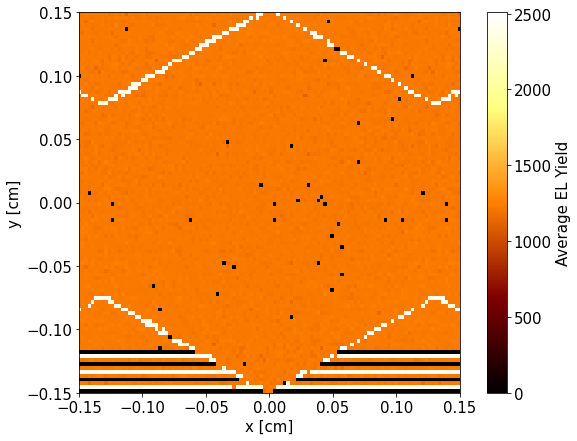

In [30]:
bmin_x=-(0.125+0.0127/2.0)
bmax_x=(0.125+0.0127/2.0)

numbins = 100

num_cells = 5

bmin_x*=(num_cells+1)
bmax_x*=(num_cells+1)

bins_x = np.linspace(bmin_x, bmax_x, numbins*(num_cells+1)-num_cells)
bw_x=(bins_x[1]-bins_x[0])/2.0
bins_centre_x = np.linspace(bmin_x+bw_x/2, bmax_x+bw_x/2, 15)[:-1]

bmin_y=-(0.125+0.0127/2)/(np.cos(30*np.pi/180))
bmax_y=(0.125+0.0127/2)/(np.cos(30*np.pi/180))

bmin_y*=(num_cells+1)
bmax_y*=(num_cells+1)

bins_y = np.linspace(bmin_y, bmax_y, (numbins)*(num_cells+1)-num_cells)
bw_y=(bins_y[1]-bins_y[0])/2.0
bins_centre_y = np.linspace(bmin_y+bw_y/2, bmax_y+bw_y/2, numbins)[:-1]

# Now bin the data
# unitcell_df['x'] = pd.cut(x=unitcell_df['x'], bins=bins_x,labels=bins_centre_x, include_lowest=True)
# unitcell_df['y'] = pd.cut(x=unitcell_df['y'], bins=bins_y,labels=bins_centre_y, include_lowest=True)


unitcell_df_avg = unitcell_df

# Now average over the events
# unitcell_df_avg = unitcell_df.groupby(['x', 'y']).mean()
# unitcell_df_avg = unitcell_df_avg.fillna(0)
# unitcell_df_avg.reset_index(inplace=True) 

# display(unitcell_df)
# display(unitcell_df_avg)


# Plot the map
fig, ax = plt.subplots(figsize =(10, 7))

# Creating plot
h, xedges, yedges = np.histogram2d(unitcell_df_avg["x"], unitcell_df_avg["y"], weights=unitcell_df_avg["Yield"], bins=[bins_x, bins_y])
im = ax.imshow(np.flip(h.T, axis=0), extent=[bins_x[0],bins_x[-1], bins_y[0], bins_y[-1]], cmap="afmhot") #, vmin=-1.5)
cbar = plt.colorbar(im, ax=ax)

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)

ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
cbar.set_label("Average EL Yield")




In [ ]:
# Load in the input file
# input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus.next.h5"
input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus_40keV.next.h5"

## True hits (deposited energy)
hits = pd.read_hdf(input_file, 'MC/hits')
hits = hits[hits["label"] == "ACTIVE"]
hits = hits.drop(columns = ["label", "hit_id", "time", "particle_id"])

# Replace nan to zeros
hits['energy'] = hits['energy'].fillna(0)

In [ ]:
# Calculate the total energy of each hit
hitsum = hits
hitsum = hitsum.drop(columns = ["x", "y", "z"])
hitsum['Esum'] = hitsum.groupby(["event_id"])["energy"].transform('sum')
hitsum = hitsum.drop(columns = ["energy"])
hitsum = hitsum.drop_duplicates()

# Get a list of events who do not deposit all their energy in the detector
# bad_events = hitsum[hitsum["Esum"] != 2.458].event_id.values

# Filter the main hit list from the bad events
# hits = hits[~hits.event_id.isin(bad_events)]

# Change the units of energy to eV
hits["energy"] = hits["energy"]*1e6
hits["ni"] = hits["energy"]/22.0
hits["ni"] = hits["ni"].round()

# Calculate the diffusion sigma
D_L = 0.38 # mm/cm^0.5
hits["sigma"] = np.sqrt(hits["z"]) * D_L # [mm]
print(hits["sigma"].max())
print(hits["sigma"].min())

print(hits["ni"].sum())

# Drop the energy and z columns
hits = hits.drop(columns = ["z", "energy"])

display(hits)


In [ ]:
rng = np.random.default_rng()

evid = -1

Yieldsum = 0

Yields = []

for ev,x,y,ni,sigma in zip(hits["event_id"], hits["x"], hits["y"], hits["ni"], hits["sigma"]):

    temp_df = pd.DataFrame()

    if (evid != ev):

        if (Yieldsum != 0):
            print("Yield: ",Yieldsum)
            Yields.append(Yieldsum)

        Yieldsum = 0
        evid = ev

        # if(ev % 10 == 0):
        print(ev)
    
    # Calculate smeared position for each electron
    mean = (x, y)
    cov = [[sigma, 0], [0, sigma]]
    x_samp, y_samp = rng.multivariate_normal(mean, cov, int(ni)).T

    # Create a dataframe and bin the x and y sample
    temp_df["x"] = x_samp
    temp_df["y"] = y_samp

    if (temp_df['x'].values.max() >  max(bins_x) or temp_df['x'].values.min() <  min(bins_x)):
        print("Error hit sample is out of range...")

    temp_df["x"] = pd.cut(x=temp_df['x'], bins=bins_x,labels=bins_centre_x, include_lowest=True)
    temp_df["y"] = pd.cut(x=temp_df['y'], bins=bins_y,labels=bins_centre_y, include_lowest=True)
    
    Yieldsum += pd.merge(temp_df, unitcell_df_avg, how ='inner', on =['x', 'y']).Yield.sum()
    # print(Yieldsum)



In [ ]:
# Make a histogram of the total photon yeilds
plt.figure()
counts, xbins, _ = plt.hist(Yields, bins = 100, histtype="step", color = "black", linewidth=3)
# plt.xlim(-200, 6200)
plt.xlabel("Yield")
plt.ylabel("Events")

xbins/=1e6

# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
bin_centers = bin_centers[:-1]

popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds = ([0, 0.8, 0], [600, 4.0, 0.5]))
print(popt)

plt.plot(bin_centers*1e6, Gaussian_(bin_centers, *popt), 'r-',label='fit: A = %5.3f, mu=%5.3fe6, sigma=%5.3fe6' % tuple(popt))
print("Resolution = ",100* 2.355*popt[2]/popt[1] )
plt.legend()
plt.show()
